### **Import Libraries and Modules**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os

### **Positional Embeddings**

In [18]:
class PositionalEmbedding(nn.Module):
  def __init__(self, width, max_seq_length):
    super().__init__()

    # Creating positional encoding
    pe = torch.zeros(max_seq_length, width)

    for pos in range(max_seq_length):
      for i in range(width):
        if i % 2 == 0:
          pe[pos][i] = np.sin(pos/(10000 ** (i/width)))
        else:
          pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/width)))

    self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
    # Add positional encoding to embeddings
    x = x + self.pe

    return x

### **Multi-Head Attention**

In [19]:
class AttentionHead(nn.Module):
  def __init__(self, width, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(width, head_size)
    self.key = nn.Linear(width, head_size)
    self.value = nn.Linear(width, head_size)

  def forward(self, x, mask=None):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    # Applying Attention Mask
    if mask is not None:
        attention = attention.masked_fill(mask == 0, float("-inf"))

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention

In [20]:
class MultiHeadAttention(nn.Module):
  def __init__(self, width, n_heads):
    super().__init__()
    self.head_size = width // n_heads

    self.W_o = nn.Linear(width, width)

    self.heads = nn.ModuleList([AttentionHead(width, self.head_size) for _ in range(n_heads)])

  def forward(self, x, mask=None):
    # Combine attention heads
    out = torch.cat([head(x, mask=mask) for head in self.heads], dim=-1)

    out = self.W_o(out)

    return out

### **Transformer Encoder**

In [21]:
class TransformerEncoder(nn.Module):
    def __init__(self, width, n_heads, r_mlp=4):
        super().__init__()
        self.width = width
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(width)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(width, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(width)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(self.width, self.width*r_mlp),
            nn.GELU(),
            nn.Linear(self.width*r_mlp, self.width)
        )


    def forward(self, x, mask=None):
        # Residual Connection After Sub-Layer 1
        x = x + self.mha(self.ln1(x), mask=mask)

        # Residual Connection After Sub-Layer 2
        x = x + self.mlp(self.ln2(x))

        return x

### **Tokenizer**

In [22]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        out = chr(2) + text + chr(3) # Adding SOT and EOT tokens
        out = out + "".join([chr(0) for _ in range(max_seq_length-len(out))]) # Adding Padding
        out = torch.IntTensor(list(out.encode("utf-8"))) # Encoding Text
        mask = torch.ones(len(out.nonzero()))
        mask = torch.cat((mask,torch.zeros(max_seq_length-len(mask)))).type(torch.IntTensor)
    else:
        out = [chr(x) for x in text[1:len(mask.nonzero())-1]]
        out = "".join(out)
        mask = None

    return out, mask

### **Text Encoder**

In [23]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, width, max_seq_length, n_heads, n_layers, emb_dim):
        super().__init__()

        self.max_seq_length = max_seq_length  # Maximum length of input sequence

        self.encoder_embedding = nn.Embedding(vocab_size, width) # Embedding Table

        self.positional_embedding = PositionalEmbedding(width, max_seq_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for _ in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        # Text Embedding
        x = self.encoder_embedding(text)

        # Positional Embedding
        x = self.positional_embedding(x)

        # Transformer Encoder
        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)

        # Takes features from the EOT Embedding
        x = x[torch.arange(text.shape[0]),torch.sub(torch.sum(mask[:,0],dim=1),1)]

        # joint multimodal embedding
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

### **Image Encoder**

In [24]:
class ImageEncoder(nn.Module):
    def __init__(self, width, img_size, patch_size, n_channels, n_layers, n_heads, emb_dim):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert width % n_heads == 0, "width must be divisible by n_heads"

        self.n_patches = (img_size[0] * img_size[1]) // (patch_size[0] * patch_size[1])

        self.max_seq_length = self.n_patches + 1

        # Patch Embedding
        self.linear_project = nn.Conv2d(n_channels, width, kernel_size=patch_size, stride=patch_size)

        # Classification Token
        self.cls_token = nn.Parameter(torch.randn(1, 1, width))

        self.positional_embedding = PositionalEmbedding(width,self.max_seq_length)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for _ in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))


    def forward(self,x):
        # Patch Embedding
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)

        # Positional Embedding
        x = torch.cat((self.cls_token.expand(x.size()[0], -1, -1),x), dim=1)
        x = self.positional_embedding(x)

        # Transformer Encoder
        for encoder_layer in self.encoder:
            x = encoder_layer(x)

        # Takes Class Tokens
        x = x[:, 0, :]

        # joint multimodal embedding
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x


### **CLIP Model**

In [25]:
class CLIP(nn.Module):
    def __init__(self, emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, emb_dim)

        self.text_encoder = TextEncoder(vocab_size, text_width, max_seq_length, text_heads, text_layers, emb_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def forward(self,image,text, mask=None):
        I_e = self.image_encoder(image)
        T_e = self.text_encoder(text, mask=mask)

        # scaled pairwise cosine similarities [n, n]
        logits = (I_e @ T_e.transpose(-2,-1)) * torch.exp(self.temperature)

        # symmetric loss function
        labels = torch.arange(logits.shape[0]).to(self.device)

        loss_i = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)

        loss = (loss_i + loss_t) / 2

        return loss

### **Dataset**

In [26]:
class FashionMNIST(Dataset):
    def __init__(self, train=True):
        self.dataset = load_dataset("fashion_mnist")

        self.transform = T.ToTensor()

        if train:
            self.split = "train"
        else:
            self.split = "test"


        self.captions = {0: "An image of a t-shirt/top",
                        1: "An image of trousers",
                        2: "An image of a pullover",
                        3: "An image of a dress",
                        4: "An image of a coat",
                        5: "An image of a sandal",
                        6: "An image of a shirt",
                        7: "An image of a sneaker",
                        8: "An image of a bag",
                        9: "An image of an ankle boot"}


    def __len__(self):
        return self.dataset.num_rows[self.split]

    def __getitem__(self,i):
        img = self.dataset[self.split][i]["image"]
        img = self.transform(img)

        cap, mask = tokenizer(self.captions[self.dataset[self.split][i]["label"]])

        mask = mask.repeat(len(mask),1)

        return {"image": img, "caption": cap, "mask": mask}

### **Training Parameters**

In [27]:
emb_dim = 32
vit_width = 9
img_size = (28,28)
patch_size = (14,14)
n_channels = 1
vit_layers = 3
vit_heads = 3
vocab_size = 256
text_width = 32
max_seq_length = 32
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 10 
batch_size = 128

### **Loading Dataset**

In [28]:
train_set = FashionMNIST(train = True)
test_set = FashionMNIST(train = False)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

In [29]:
print(train_set[0]["image"].shape)
print(train_set[0]["caption"].shape)
print(train_set[0]["mask"].shape)
print(train_set[0]["caption"])
print(train_set[0]["mask"])

torch.Size([1, 28, 28])
torch.Size([32])
torch.Size([32, 32])
tensor([  2,  65, 110,  32, 105, 109,  97, 103, 101,  32, 111, 102,  32,  97,
        110,  32,  97, 110, 107, 108, 101,  32,  98, 111, 111, 116,   3,   0,
          0,   0,   0,   0], dtype=torch.int32)
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)


### **Training**

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_loss = np.inf
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
        loss = model(img,cap,mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Saves model if it performed better than the previous best
    print(f"Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.3f}")
    if loss.item() <= best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "../src/clip.pt")
        print("Model Saved.")

Using device:  cuda (NVIDIA GeForce RTX 3050 Ti Laptop GPU)
Epoch [1/10], Batch Loss: 3.138
Model Saved.
Epoch [2/10], Batch Loss: 2.803
Model Saved.
Epoch [3/10], Batch Loss: 2.678
Model Saved.
Epoch [4/10], Batch Loss: 2.864
Epoch [5/10], Batch Loss: 2.800
Epoch [6/10], Batch Loss: 2.790
Epoch [7/10], Batch Loss: 2.594
Model Saved.
Epoch [8/10], Batch Loss: 2.719
Epoch [9/10], Batch Loss: 2.673
Epoch [10/10], Batch Loss: 2.625


### **Testing**

In [31]:
# Loading Best Model
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("../src/clip.pt", map_location=device))

# Getting dataset captions to compare images to
text = torch.stack([tokenizer(x)[0] for x in test_set.captions.values()]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in test_set.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in test_loader:
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.image_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * (image_features @ text_features.T)).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
        pred = torch.stack([tokenizer(test_set.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))
        total += len(labels)

print(f'\nModel Accuracy: {100 * correct // total} %')

/tmp/ipykernel_16405/437209580.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../src/clip.pt", map_location=device))



Model Accuracy: 84 %


### **Zero-Shot Classification**

/tmp/ipykernel_16405/577610390.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../src/clip.pt", map_location=device))


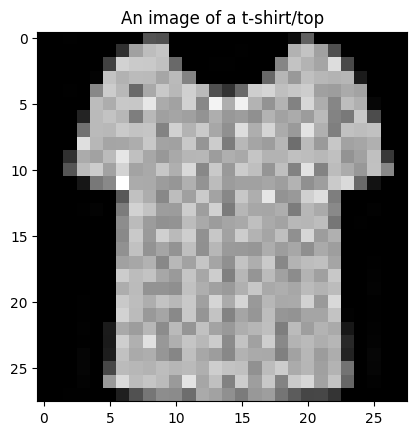


Top predictions:

     t-shirt/top: 85.21%
           shirt: 13.21%
          sandal: 1.45%
        pullover: 0.13%
            coat: 0.00%


In [32]:
# Loading Best Model
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("../src/clip.pt", map_location=device))


# Captions to compare images to
class_names =["t-shirt/top",
                        "trousers",
                        "pullover",
                        "dress",
                        "coat",
                        "sandal",
                        "shirt",
                        "sneaker",
                        "bag",
                        "ankle boot"]

# class_names =["An image of a t-shirt/top",
#                         "An image of trousers",
#                         "An image of a pullover",
#                         "An image of a dress",
#                         "An image of a coat",
#                         "An image of a sandal",
#                         "An image of a shirt",
#                         "An image of a sneaker",
#                         "An image of a bag",
#                         "An image of an ankle boot"]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 1000

img = test_set[idx]["image"][None,:]
plt.imshow(  img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
  image_features = model.image_encoder(img)
  text_features = model.text_encoder(text, mask=mask)


image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")